# One Plane 2D model
- The following notebook contains the solution for optimal control for the one plane problem in 2D
- The solver is in the package "Model_2D_Package"
- First is the solution from the bolza definition
- Then the solution from the min -w, where w<=h(t) for all t
- Last is a function for reconstructing a more detail trajectory when solving for low u values

In [20]:
%reset -f

import matplotlib.pyplot as plt
from casadi import *

import importlib
import Model_2D_Package.One_Plane_2D_solvers as model
importlib.reload(model)


<module 'Model_2D_Package.One_Plane_2D_solvers' from 'C:\\Users\\irmas\\Documents\\TUM\\CaseCourse\\CasADi\\Main\\Model_2D\\Model_2D_Package\\One_Plane_2D_solvers.py'>

## Bolza model

Total number of variables............................:      480
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      160
                     variables with only upper bounds:       80
Total number of equality constraints.................:      401
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       80
        inequality constraints with only upper bounds:        0


Number of Iterations....: 52

                                   (scaled)                 (unscaled)
Objective...............:   1.7605953661261952e+04    1.4942447976433384e+12
Dual infeasibility......:   1.4068746168049984e-11    1.1940364705848329e-03
Constraint violation....:   1.8189894035458565e-12    1.8189894035458565e-12
Variable bound violation:   9.9999999392252903e-09    9.9999999392252903e-09
Complementari

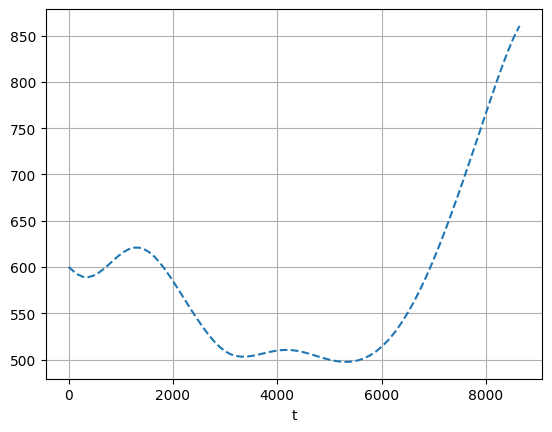

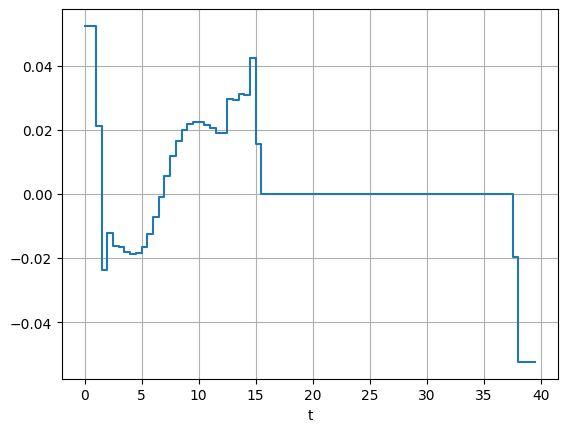

0

In [17]:

w_opt,J_opt = model.solve_ocp_one_plane_bolza(k_value=1.0)

# plot
print(J_opt)
model.plot_one_plane_2D(w_opt, True)

## min -w Model

Total number of variables............................:      481
                     variables with only lower bounds:       81
                variables with lower and upper bounds:       80
                     variables with only upper bounds:       80
Total number of equality constraints.................:      401
Total number of inequality constraints...............:      160
        inequality constraints with only lower bounds:       80
   inequality constraints with lower and upper bounds:       80
        inequality constraints with only upper bounds:        0


Number of Iterations....: 55

                                   (scaled)                 (unscaled)
Objective...............:  -5.1310875594258903e+02   -5.1310875594258903e+02
Dual infeasibility......:   6.6982964081557196e-09    6.6982964081557196e-09
Constraint violation....:   1.3511680663214065e-09    1.3511680663214065e-09
Variable bound violation:   9.9573836398469950e-09    9.9573836398469950e-09
Complementari

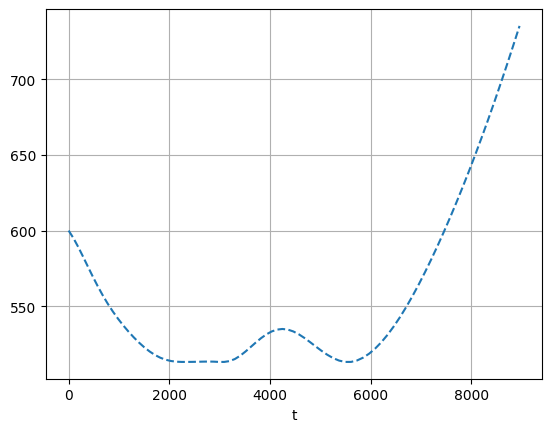

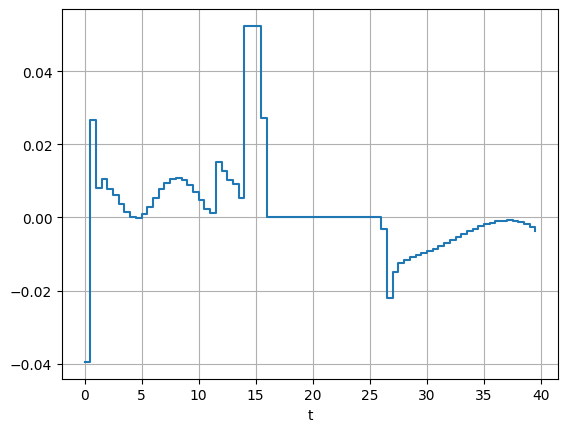

0

In [21]:

w_opt,J_opt = model.solve_ocp_one_plane_min_h(k_value=1.0)
print(-J_opt)
model.plot_one_plane_2D(w_opt,False)

## Reconstruction function

Optimal cost J* = 1.71212e+12
512.9826268699303


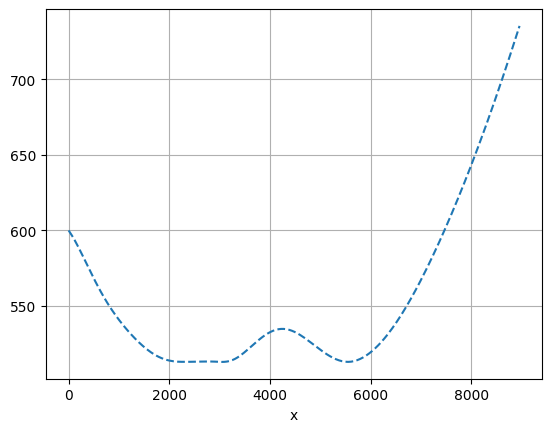

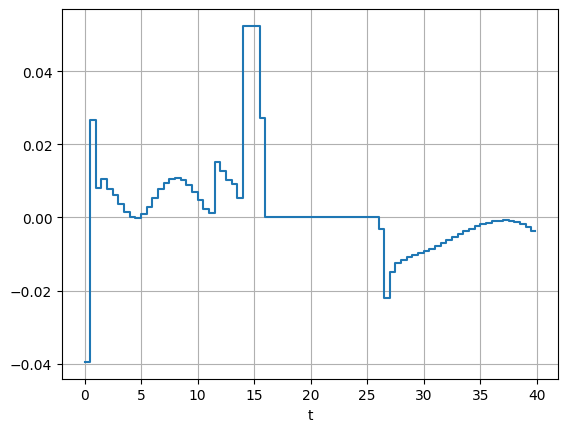

In [22]:

# Plot
X,U,J,T = model.reconstruction_one_plane_2D(model.u_opt_return(w_opt, False), k_value=1, multipler=4)


x1_opt = X[0::5]    # start at index 0, get every 6th:
x2_opt = X[1::5]   
x3_opt = X[2::5]  
x4_opt = X[3::5] 
x5_opt = X[4::5]


print("Optimal cost J* =", J)
print(min(x2_opt))

plt.figure(1)
plt.clf()
plt.plot(x1_opt, x2_opt, '--')
plt.xlabel('x')
plt.grid()
plt.show()

plt.figure(2)
plt.clf()
plt.step(T[:-1], U, where='post')
plt.xlabel('t')
plt.grid()
plt.show()  

